## Objective

We can find a bunch of examples but there arent that many continuous BN examples

https://www.bnlearn.com/bnrepository/

We can also manually create our own examples either fully synhetic with random variable names or with a combination of synthetic + LLMs / manual

> PGMPY does not support inference in Linear Gaussian networks. However, we know that a LG BN is equivalent to a Multivariate Gaussian distribution, so we can transform it into a multivariate and do the inference

Docs: https://pgmpy.org/models/gaussianbn.html

In [ ]:
import sys
from pathlib import Path

from pgmpy.models import LinearGaussianBayesianNetwork

# Set the base path
base_path = Path("../../")  # One level up from the current working directory

# Add the src/ directory to sys.path using base_path
sys.path.append(str((base_path / "src").resolve()))

from bn_utils import draw_bayesian_network
from inference_continuous import query_lgbn

## Create BN with defined structure and random parameters

In [40]:
# Taking the example of the cancer model.

model = LinearGaussianBayesianNetwork(
    [
        ("Pollution", "Cancer"),
        ("Smoker", "Cancer"),
        ("Cancer", "Xray"),
        ("Cancer", "Dyspnoea"),
    ]
)

model.get_random_cpds(inplace=True)

# Access attributes of the model
nodes = model.nodes()
edges = model.edges()
cpds = model.get_cpds()

cpd_strings = []
for cpd in model.get_cpds():
    cpd_strings.append(str(cpd))

cpds_as_string = "\n".join(cpd_strings)

# print(f"Nodes in the model: {nodes} \n")
# print(f"Edges in the model: {edges} \n")
# print(f"CPDs in the model: ")

print(cpds_as_string)

# print("\n" + "="*50 + "\n")

P(Pollution) = N(0.305; 1.04)
P(Cancer | Pollution, Smoker) = N(0.678*Pollution + -0.586*Smoker + 0.244; 0.909)
P(Smoker) = N(1.446; 0.102)
P(Xray | Cancer) = N(-0.623*Cancer + -0.458; 0.135)
P(Dyspnoea | Cancer) = N(1.218*Cancer + -0.503; 0.271)


## Draw the structure

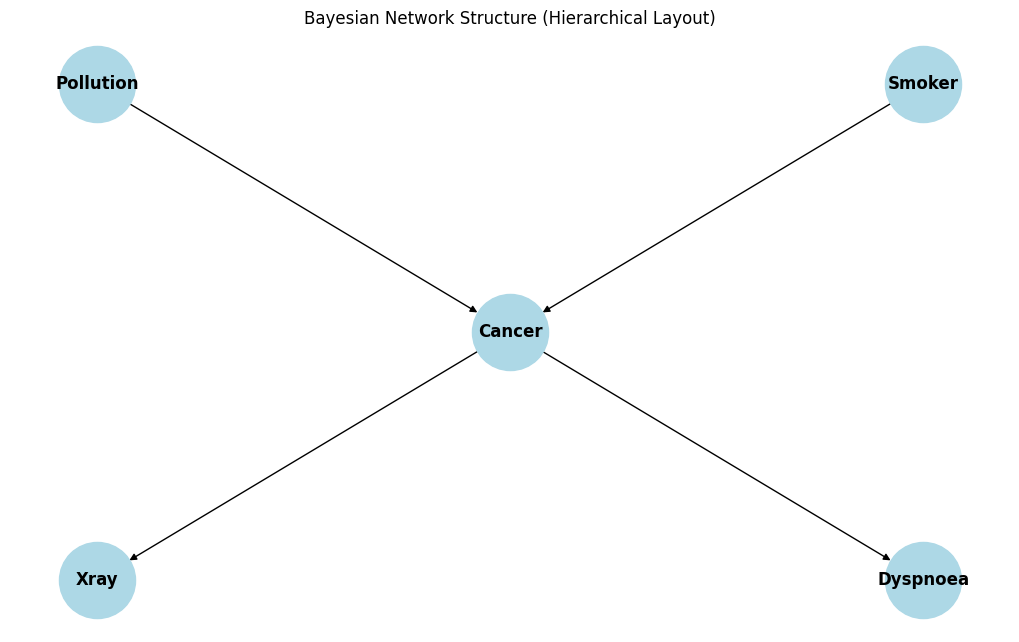

In [39]:
draw_bayesian_network(model)

## Inference

In [31]:
# Import additional libraries for probability calculations
from scipy.stats import norm

## Inference Examples

Now let's perform some inference queries on our Linear Gaussian BN using the multivariate Gaussian representation.


In [32]:
# Example 1: Simple conditional query
# What is P(Pollution | Dyspnoea = 0.5)?
result = query_lgbn(model, 'Pollution', evidence={'Dyspnoea': 0.5})
print("Query: P(Pollution | Dyspnoea = 0.5)")
print(f"Mean: {result['mean']:.4f}")
print(f"Std: {result['std']:.4f}")
print(f"Variance: {result['variance']:.4f}")
print()


Query: P(Pollution | Dyspnoea = 0.5)
Mean: 0.8406
Std: 0.8544
Variance: 0.7300



In [33]:
# Example 2: Multiple evidence variables
# What is P(Cancer | Xray = -1.0, Smoker = 2.0)?
result = query_lgbn(model, 'Cancer', evidence={'Xray': -1.0, 'Smoker': 2.0})
print("Query: P(Cancer | Xray = -1.0, Smoker = 2.0)")
print(f"Mean: {result['mean']:.4f}")
print(f"Std: {result['std']:.4f}")
print(f"Variance: {result['variance']:.4f}")
print()


Query: P(Cancer | Xray = -1.0, Smoker = 2.0)
Mean: 1.3450
Std: 0.3159
Variance: 0.0998



In [34]:
# Example 3: Query with probability calculation
# What is P(0 < Pollution < 1 | Dyspnoea = 0.5)?
result = query_lgbn(model, 'Pollution', evidence={'Dyspnoea': 0.5}, prob_range=(0, 1))
print("Query: P(0 < Pollution < 1 | Dyspnoea = 0.5)")
print(f"Mean: {result['mean']:.4f}")
print(f"Std: {result['std']:.4f}")
print(f"P(0 < Pollution < 1): {result['probability']:.4f}")
print()


Query: P(0 < Pollution < 1 | Dyspnoea = 0.5)
Mean: 0.8406
Std: 0.8544
P(0 < Pollution < 1): 0.4114



In [35]:
# Example 4: Query with upper bound only
# What is P(Pollution > 1.0 | Dyspnoea = 0.5)?
result = query_lgbn(model, 'Pollution', evidence={'Dyspnoea': 0.5}, prob_range=(1.0, None))
print("Query: P(Pollution > 1.0 | Dyspnoea = 0.5)")
print(f"Mean: {result['mean']:.4f}")
print(f"Std: {result['std']:.4f}")
print(f"P(Pollution > 1.0): {result['probability']:.4f}")
print()

# Example 5: Query with lower bound only
result = query_lgbn(model, 'Cancer', evidence={'Smoker': 2.0, 'Pollution': 0.8}, prob_range=(None, 0))
print("Query: P(Cancer < 0 | Smoker = 2.0, Pollution = 0.8)")
print(f"Mean: {result['mean']:.4f}")
print(f"Std: {result['std']:.4f}")
print(f"P(Cancer < 0): {result['probability']:.4f}")
print()

Query: P(Pollution > 1.0 | Dyspnoea = 0.5)
Mean: 0.8406
Std: 0.8544
P(Pollution > 1.0): 0.4260

Query: P(Cancer < 0 | Smoker = 2.0, Pollution = 0.8)
Mean: 1.3152
Std: 0.3139
P(Cancer < 0): 0.0000



### Computing Probabilities

We can also compute probabilities for specific ranges or values using the conditional distribution.


In [36]:
# Example 5: Computing confidence intervals
# Calculate the 95% confidence interval for P(Pollution | Dyspnoea = 0.5)
result = query_lgbn(model, 'Pollution', evidence={'Dyspnoea': 0.5})

# Calculate the 95% confidence interval manually
z_score = norm.ppf(0.975)  # 97.5th percentile for 95% CI
margin = z_score * result['std']
ci_lower = result['mean'] - margin
ci_upper = result['mean'] + margin

print("Query: 95% Confidence Interval for P(Pollution | Dyspnoea = 0.5)")
print(f"Mean: {result['mean']:.4f}")
print(f"Std: {result['std']:.4f}")
print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
print()


Query: 95% Confidence Interval for P(Pollution | Dyspnoea = 0.5)
Mean: 0.8406
Std: 0.8544
95% CI: [-0.8341, 2.5152]



### Marginal Queries

The helper function also supports marginal queries (no evidence)

In [37]:
# Example 6: Marginal query (no evidence)
result = query_lgbn(model, 'Cancer')
print("Marginal distribution of Cancer:")
print(f"Mean: {result['mean']:.4f}")
print(f"Std: {result['std']:.4f}")
print()

Marginal distribution of Cancer:
Mean: 1.4460
Std: 0.3199

